Another method for analyzing the importance of web pages is *Hubs and Authorities*, also known as *HITS (Hyperlink-Induced Topic Search)*, proposed shortly after PageRank was implemented. This section describes how this method is implemented.

## Description of Hubs and Authorities

While PageRank assesses the importance of pages in a somewhat one-directional way (via in-links to pages), the HITS methodology revolve around two notions of importance:

1. *Authorities* - Pages are assessed as important because they *provide information* about a topic.
2. *Hubs* - Pages are assessed as important because they tell *where to go* to get information about a topic.

Just like PageRank, HITS makes use of links as a way of assessing the importance of pages. 

It does this in a recursive manner:
- A page is a good **hub** if it **links to** good authorities
- A page is a good **authority** if it is **linked by** good hubs

## The Link Matrix

The HITS algorithm also makes use of a matrix to compute the score of *'hubbiness'* or *authority* of pages. Let's assume that these scores are represented by the vectors $\textbf{h}$ and $\textbf{a}$.
Further assume that $n$ is the number of pages in the network.

To compute $\textbf{h}$ and $\textbf{a}$, we need a matrix to contain information about the links.
For the HITS algorithm, this matrix is called the *link matrix* $L$, of size $n$ x $n$. 

If we denote the elements of $L$ as $\ell_{ij}$, we have:

$
    \ell_{ij}=\left\{
    \begin{array}{@{}ll@{}}
    1, & \text{if there is a link from page } i \text{ to } j \\
    0, & \text{otherwise}
    \end{array}\right.
$


Note that, compared to the Transition Matrix of PageRank, the *direction* for putting entries in the matrix is reversed, since for the transition matrix, the entries are defined according to links from **$j$ to $i$**. Aside from the matrix $L$, hits also makes use of its transpose, $L^T$. Note that $L^T$ is similar to the transition matrix, only that its entries are $1$ for instead of $1/n$ for the non-zero elements.

Given the earlier discussion on graph notations, we observe that the Link Matrix is actually nothing but the adjacency matrix of the graph.

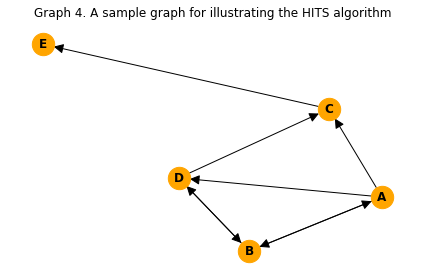

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

G4 = nx.DiGraph()
G4.add_nodes_from(["A","B","C","D","E"])
G4.add_edges_from([
    ("A","B"), ("A","C"), ("A","D"), 
    ("B","A"), ("B","D"),
    ("C","E"),    
    ("D","B"), ("D","C")
])

plt.figure()  
plt.title("Graph 4. A sample graph for illustrating the HITS algorithm")
nx.draw(G4, node_size=500, node_color='orange', with_labels=True, font_weight='bold', arrowsize=20)
plt.tight_layout()
plt.show()

The link matrix or adjacency matrix of $G4$ is given by:

In [2]:
nx.adjacency_matrix(G4).toarray()

array([[0, 1, 1, 1, 0],
       [1, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0]])

## Deriving the HITS update rule

Recall in PageRank that the score of a page is distributed to its successors. In the case of HITS, the score passed to the successors. In order to prevent values from growing without bounds, the values are normally scaled so that the largest value of a component is 1. 

Given constants $\lambda$ and $\mu$ to represent the scaling factor, we can describe the iteration step for updating $\textbf{h}$ and $\textbf{a}$ as follows:
* $\textbf{h'}  = \lambda L \textbf{a} $
* $\textbf{a'}  = \mu L^T \textbf{h} $

Since the hubbiness of a page is proportional to the authority of its *successors*, and the authority of a page is proportional to the hubbiness of its *predecessors*, we can actually compute for hubbiness independently, giving us a form that allows us to compute the two values independently.
* $\textbf{h'}  = \lambda \mu L L^{T} \textbf{a} $
* $\textbf{a'}  = \lambda \mu L^T
L \textbf{h} $

However, since $L L^{T}$ and $L^{T} L$ are not sparse, it is actually better to compute  $\textbf{h}$ and $\textbf{a}$ recursively. We outline method in the next subsection.

## HITS Algorithm

We can summarize the HITS algorithm as follows:

Initialize $\textbf{h}$ and $\textbf{a}$ to a vectors of 1's (of size $n$)

Iterate:

1. Compute $\textbf{a}  = \mu L^T \textbf{h} $
2. Scale $\textbf{a}$ so that the largest component is 1 (i.e., divide each element by the maximum value.)
3. Compute $\textbf{h}  = \mu L^T \textbf{a} $
4. Scale $\textbf{h}$ so that the largest component is 1 

 Until changes to $\textbf{h}$ and $\textbf{a}$ are sufficiently small.

We implement the hits algorithm below.

In [3]:
def hits(L, tol=10**-6, max_iter=100):
    """Compute the PageRank of a given Transition Matrix

    Parameters
    ----------
    L : numpy array
        Link Matrix: Array of shape (n, n), where n is the number of nodes in the network
    tol : float
        Tolerance: Iteration stops if the distance between previous and updated PageRank vectors 
        goes below this value
    max_iter : integer
        Maximum number of iterations
    Returns
    -------
    h, a : tuple of numpy array
        Vectors of size n containing the hub and authority values 
    """
    h = np.ones(L.shape[0])
    a = np.ones(L.shape[0])
    delta = 1/tol # initialize to a large number
    i = 0
    while delta > tol:
        i += 1
        
        # save old values
        prev_h = h
        prev_a = a

        # update a
        a = L.T.dot(h)    
        # scale a
        a = a/np.max(a)

        # update h
        h = L.dot(a)
        # scale h
        h = h/np.max(h)

        delta = np.mean([
                np.sum(np.abs(h-prev_h)), 
                np.sum(np.abs(a-prev_a))
                ])
        if i >= max_iter:
            break        
    return h, a

In [4]:
import numpy as np

L = nx.adjacency_matrix(G4).toarray()
h, a = hits(L)
print(f'h: {h}')
print(f'a: {a}')

h: [1.00000000e+00 3.58257838e-01 1.02588408e-11 7.16515005e-01
 0.00000000e+00]
a: [2.08712567e-01 1.00000000e+00 1.00000000e+00 7.91288371e-01
 2.86353830e-11]


**EXERCISES**
1. Identify pages that can be considered as examples of hubs and authorities
2. Calculate the $h$ and $a$ scores for Graph 1 in the previous section.

**REFERENCE**

* Jure Leskovec, Anand Rajaraman, and Jeffrey D Ullman. Mining of massive datasets, chapter 5. Cambridge University Press, 3rd edition, 2019. http://www.mmds.org/. All figures, except Figure 2, were cropped from this book. Figure 2 was adapted from the presentation slides made available by the authors of the same book.